In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import random
from torchsummary import summary

# Video

In [2]:
TrDict = {
	"csrt": cv2.legacy.TrackerCSRT_create,
	"kcf": cv2.TrackerKCF_create,
	"boosting": cv2.legacy.TrackerBoosting_create,
	"mil": cv2.TrackerMIL_create,
	"tld": cv2.legacy.TrackerTLD_create,
	"medianflow": cv2.legacy.TrackerMedianFlow_create,
	"mosse": cv2.legacy.TrackerMOSSE_create
    }
multi_trackers = cv2.legacy.MultiTracker_create()

In [3]:
v = cv2.VideoCapture('data\Arsenal_goal.mp4')
multi_trackers = cv2.legacy.MultiTracker_create()
ret, frame = v.read()
frame1 = frame
for i in range(1):
    cv2.imshow("Frame", frame)
    bb_i = cv2.selectROI("Frame", frame)
    tracker_i = TrDict['csrt']()
    multi_trackers.add(tracker_i, frame, bb_i)
    print(bb_i)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\dxt.cpp:3508: error: (-215:Assertion failed) type == CV_32FC1 || type == CV_32FC2 || type == CV_64FC1 || type == CV_64FC2 in function 'cv::dft'


: 

In [ ]:
while True:
    ret, frame = v.read()
    if not ret:
        break
    (success, boxes) = multi_trackers.update(frame)
    for box in boxes:
        (x,y,w,h) = [int(a) for a in box]
        cv2.rectangle(frame, (x,y), (x+w,y+h), (100, 255,0), 2)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(5) & 0xFF
    if key == ord("q"):
        break
v.release()
cv2.destroyAllWindows()

True

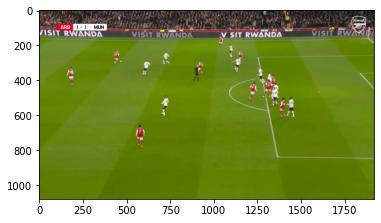

In [ ]:
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
cv2.imwrite("snap.png", frame1)

In [ ]:
boxes

array([[574., 478.,  94., 170.]])

# Model

In [ ]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
from torchvision.transforms import transforms as transforms


model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')

model.eval()
model.to(device)


transform = transforms.Compose([
transforms.ToTensor()
])

In [ ]:
image = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
original_image = image.copy()

image = transform(image)
image = image.unsqueeze(0).to(device)

with torch.no_grad():
    # forward pass of the image through the modle
    outputs = model(image)
    
threshold = 0.8
# get all the scores
scores = list(outputs[0]['scores'].detach().cpu().numpy())
# index of those scores which are above a certain threshold
thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
thresholded_preds_count = len(thresholded_preds_inidices)
# get the masks
masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
# discard masks for objects which are below threshold
masks = masks[:thresholded_preds_count]
# get the bounding boxes, in (x1, y1), (x2, y2) format
boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
# discard bounding boxes below threshold value
boxes = boxes[:thresholded_preds_count]
# get the classes labels
labels = [class_names[i] for i in outputs[0]['labels']]
# discard those below the threshold
labels = labels[:thresholded_preds_count]


print(boxes)

[[(554, 654), (605, 788)], [(696, 489), (741, 607)], [(1412, 496), (1465, 612)], [(160, 322), (201, 435)], [(1201, 411), (1249, 520)], [(1375, 501), (1416, 611)], [(427, 231), (460, 307)], [(1087, 192), (1110, 268)], [(591, 287), (637, 373)], [(884, 301), (940, 407)], [(1323, 423), (1374, 549)], [(1116, 269), (1170, 358)], [(710, 237), (745, 304)], [(1030, 147), (1056, 212)], [(1284, 396), (1331, 505)], [(463, 286), (476, 299)], [(1141, 226), (1164, 291)], [(1306, 349), (1334, 417)], [(1408, 9), (1442, 105)], [(1327, 370), (1352, 433)]]


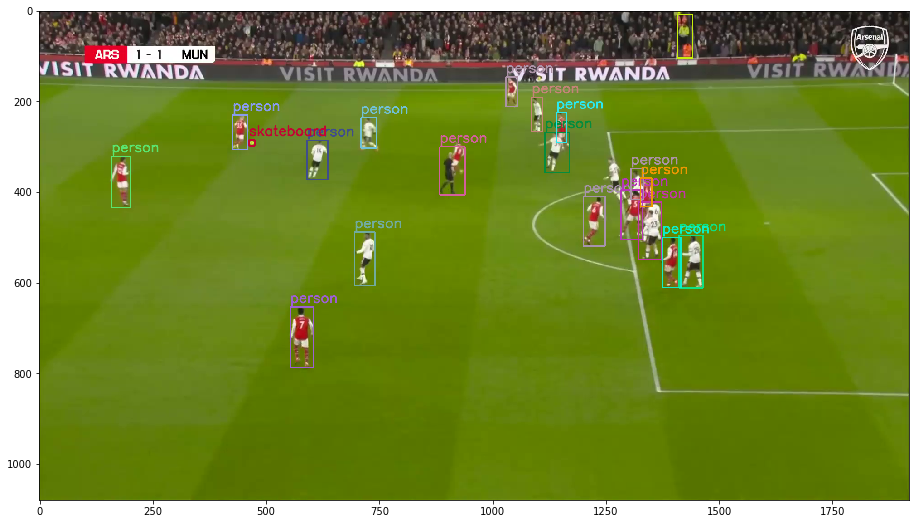

In [ ]:
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

def draw_segmentation_map(image, masks, boxes, labels):
    for i in range(len(masks)):
        
        # apply a random color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

result = draw_segmentation_map(original_image, masks, boxes, labels)
plt.figure(figsize = (16,9))
plt.imshow(result, interpolation='nearest')

## Let's try seperating those...

In [ ]:
# get rid of the ball marker lol

def people_only(labels, masks, boxes):
    labels, masks, boxes = np.array(labels), np.array(masks), np.array(boxes)

    people = np.where(labels == 'person', True, False)

    labels = labels[people]
    masks = masks[people]
    boxes = boxes[people]

    return labels, masks, boxes

labels, masks, boxes = people_only(labels, masks, boxes)


In [ ]:
def get_colour(original_image, masks, cnnBoxes, labels):
    #cnnBoxes = cnnBoxes[:-2]
    colour_vectors = []
    for bb in cnnBoxes:
        # crop the image to the player
        [(x1,y1),(x2,y2)] = bb
        img = original_image[y1:y2, x1:x2]
        #plt.imshow(img), plt.show()

        # find a vector that represents the colours here
        # convert to LAB colour space (easier to filter out the green pitch)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        a_channel = lab[:,:,1]
        
        th = cv2.threshold(a_channel,100,255,cv2.THRESH_BINARY)[1]
        masked = cv2.bitwise_and(img, img, mask = th)    # contains dark background
        m1 = masked.copy()
        m1[th==0]=(255,255,255)  
        #plt.imshow(m1), plt.show()
        
        average = img.mean(axis=0).mean(axis=0)
        pixels = np.float32(img.reshape(-1, 3))

        n_colors = 10
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS

        _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 20, flags)
        _, counts = np.unique(labels, return_counts=True)
        
        indices = np.argsort(counts)[::-1]   
        freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
        rows = np.int_(img.shape[0]*freqs)

        dom_patch = np.zeros(shape=img.shape, dtype=np.float32)
        for i in range(len(rows) - 1):
            dom_patch[rows[i]:rows[i + 1], :, :] += np.float32(palette[indices[i]])

        dominant = palette[np.argmax(counts)]
        img_colour_vector = dom_patch[:,0,:].mean(axis=0)

        img_colour_vector = palette.mean(axis=0)
        #print(img_colour_vector)
        colour_vectors.append(img_colour_vector)
        #print(img_colour_vector)
    
    return np.array(colour_vectors)


colour_vectors = get_colour(original_image, masks, boxes, labels)
print(len(colour_vectors))
#print(colour_vectors)

19


In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(colour_vectors, 2, None, criteria, 10, flags)

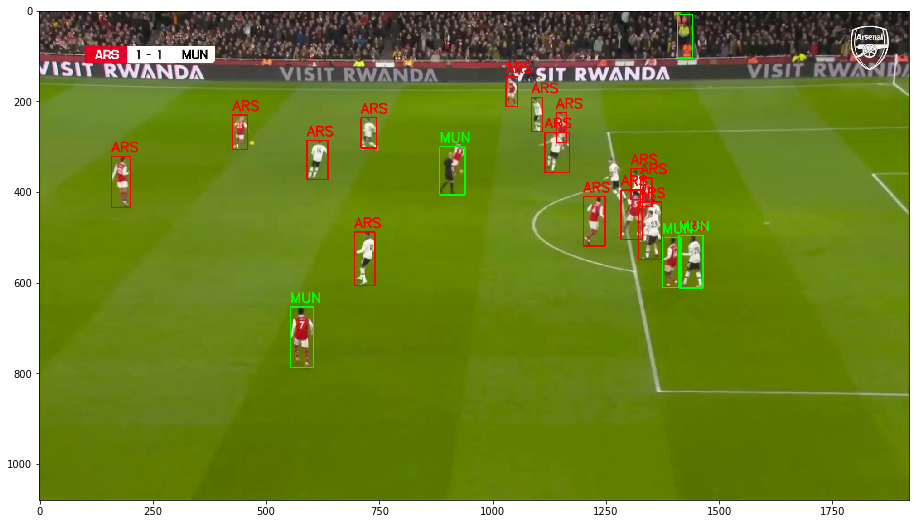

In [ ]:
COLOURS = [[255,0,0], [0,255,0], [0,0,255]]

def draw_classified_map(image, boxes, labels):
    names = ["ARS", "MUN"]
    team_labels = []
    for i, label in enumerate(labels):
        # apply a color mask to each object
        idx = int(label)
        color = COLOURS[int(label)]  
        team_labels.append(names[idx])      
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , names[idx], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color=color, 
                    thickness=2, lineType=cv2.LINE_AA)
    return image, team_labels

result, team_labels = draw_classified_map(original_image, boxes, labels)
plt.figure(figsize = (16,9))
plt.imshow(result, interpolation='nearest')

In [ ]:
def convertBoxes(cnnBoxes):
    newBoxes = []
    for bb in cnnBoxes:
        h = bb[1][0] - bb[0][0]
        w = bb[1][1] - bb[0][1]
        x = bb[0][0]
        y = bb[0][1]
        newBoxes.append((x,y,h,w))
    return newBoxes

def makeTrackers(cnnBoxes):
    multi_trackers = cv2.legacy.MultiTracker_create()
    boxes = convertBoxes(cnnBoxes)

    for bb_i in boxes:
        tracker_i = TrDict['csrt']()
        multi_trackers.add(tracker_i, frame, bb_i)

    return multi_trackers


v = cv2.VideoCapture('data\Arsenal_goal.mp4')
ret, frame = v.read()
frame1 = frame
#print(boxes[0])
multi_trackers = makeTrackers(boxes)

while True:
    ret, frame = v.read()

    if not ret:
        break
    (success, boxes2) = multi_trackers.update(frame)
    for index, box in enumerate(boxes2):
        (x,y,w,h) = [int(a) for a in box]
        cv2.rectangle(frame, (x,y), (x+w,y+h), (100, 255,0), 2)
        cv2.putText(frame, team_labels[index], (x, y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255,0), 
                    thickness=2, lineType=cv2.LINE_AA)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(5) & 0xFF
    if key == ord("q"):
        break
v.release()
cv2.destroyAllWindows()

In [ ]:
(x,y,w,h) = [int(a) for a in boxes[0]]
cv2.rectangle(frame, (x,y), (x+w,y+h), (100, 255,0), 2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
boxes

array([[ 543.,  652.,   51.,  134.],
       [ 698.,  491.,   47.,  123.],
       [1392.,  495.,   53.,  116.],
       [ 123.,  327.,   42.,  115.],
       [1217.,  430.,   45.,  103.],
       [1355.,  497.,   43.,  114.],
       [ 432.,  230.,   32.,   73.],
       [1089.,  196.,   23.,   75.],
       [ 609.,  287.,   46.,   86.],
       [ 859.,  296.,   56.,  106.],
       [1324.,  425.,   49.,  121.],
       [1103.,  262.,   56.,   93.],
       [ 653.,  239.,   34.,   64.],
       [1024.,  142.,   24.,   60.],
       [1281.,  390.,   50.,  116.],
       [ 463.,  285.,   12.,   12.],
       [1136.,  218.,   23.,   66.],
       [1306.,  350.,   26.,   63.],
       [1402.,    9.,   34.,   96.],
       [1326.,  375.,   25.,   63.],
       [1063.,   93.,   37.,   67.],
       [1255.,  321.,   45.,  119.]])